### Importing all the Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


import joblib
from joblib import Memory
import os

from tqdm import tqdm

In [3]:
# Read the dataset
path = r"C:\Users\krishna kumar\Desktop\Innomatics Research Lab\Internship Stuffs\Machine Learning and MLOPs\Sentiment Analysis of Real-time Flipkart Product Reviews\reviews_datasets\reviews_badminton\data.csv"
data = pd.read_csv(path)

In [4]:
data

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1
...,...,...,...,...,...,...,...,...
8513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
8514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
8515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
8516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


#### Exploratory Data Analysis

##### Data Cleaning

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reviewer Name    8508 non-null   object 
 1   Review Title     8508 non-null   object 
 2   Place of Review  8468 non-null   object 
 3   Up Votes         8508 non-null   float64
 4   Down Votes       8508 non-null   float64
 5   Month            8053 non-null   object 
 6   Review text      8510 non-null   object 
 7   Ratings          8518 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 532.5+ KB


In [6]:
# Check for the null values
data.isnull().sum()

Reviewer Name       10
Review Title        10
Place of Review     50
Up Votes            10
Down Votes          10
Month              465
Review text          8
Ratings              0
dtype: int64

In [7]:
data.columns

Index(['Reviewer Name', 'Review Title', 'Place of Review', 'Up Votes',
       'Down Votes', 'Month', 'Review text', 'Ratings'],
      dtype='object')

In [8]:
# Dropping the features that are not necessary for our usecase
dataset = data[["Review text", "Ratings"]]

In [9]:
dataset.isnull().sum()

Review text    8
Ratings        0
dtype: int64

In [10]:
# Dropping the null datapoints
dataset = dataset.dropna()
# Checking for the null values
dataset.isnull().sum()

Review text    0
Ratings        0
dtype: int64

In [11]:
dataset.head()

,Review text,Ratings
0,"Nice product, good quality, but price is now r...",4
1,They didn't supplied Yonex Mavis 350. Outside ...,1
2,Worst product. Damaged shuttlecocks packed in ...,1
3,"Quite O. K. , but nowadays the quality of the...",3
4,Over pricedJust â?¹620 ..from retailer.I didn'...,1


In [12]:
dataset["Ratings"].value_counts()

5    5079
4    1744
1     766
3     615
2     306
Name: Ratings, dtype: int64

In [13]:
# Normalizing the numbers
dataset["Ratings"].value_counts(normalize = True)

5    0.596827
4    0.204935
1    0.090012
3    0.072268
2    0.035958
Name: Ratings, dtype: float64

In [14]:
# Defining a lambda function separately
lambda_fun = lambda rating : "Positive" if rating > 3 else "Negative"
# Applying the lambda function on the entire column of Ratings
dataset["Sentiments"] = dataset["Ratings"].apply(lambda_fun)
# Dropping the Ratings column after conversion
dataset = dataset.drop("Ratings", axis = 1)
# Renaming the column name
dataset = dataset.rename(columns = {"Review text" : "Reviews"})

In [15]:
dataset["Sentiments"].value_counts()

Positive    6823
Negative    1687
Name: Sentiments, dtype: int64

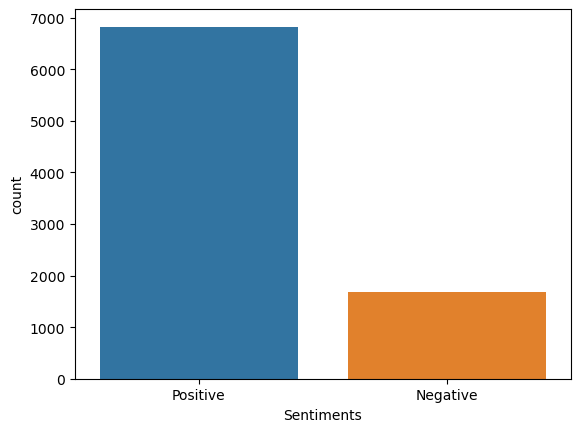

In [16]:
sns.countplot(x = "Sentiments", data = dataset)
plt.show()

#### Splitting the data into train and test

In [17]:
# Defining the input data
X = dataset["Reviews"]
# defining the output/target data
y = dataset["Sentiments"]

In [18]:
X

0       Nice product, good quality, but price is now r...
1       They didn't supplied Yonex Mavis 350. Outside ...
2       Worst product. Damaged shuttlecocks packed in ...
3       Quite O. K. , but nowadays  the quality of the...
4       Over pricedJust â?¹620 ..from retailer.I didn'...
                              ...                        
8505    Delivered before time but price is high from m...
8506    up to the mark but same is available in market...
8507                         Nice delivery speedREAD MORE
8508    No complaints about the item . Its the best on...
8509    Not sure why we have charged for this product ...
Name: Reviews, Length: 8510, dtype: object

In [19]:
y

0       Positive
1       Negative
2       Negative
3       Negative
4       Negative
          ...   
8505    Negative
8506    Positive
8507    Positive
8508    Positive
8509    Negative
Name: Sentiments, Length: 8510, dtype: object

In [20]:
X.shape, y.shape

((8510,), (8510,))

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

In [22]:
X_train

4413               The shuttles are very good...READ MORE
6991    really worth paying..best suited for outdoor a...
2952                                        GoodREAD MORE
4653                                        GoodREAD MORE
987     One of the best shuttle for outdoor playREAD MORE
                              ...                        
4829    Thanks flipkart for delivering in just 12hrs.R...
7291    Love Flipkart for wonderful offer and the deli...
1344                                 Not DurableREAD MORE
7293                                good productREAD MORE
1289                                        NiceREAD MORE
Name: Reviews, Length: 6808, dtype: object

In [23]:
X_train.shape

(6808,)

### WordCloud Before Data Preprocessing

In [24]:
def display_wc(data):
    # Define the parameters of the wordcloud
    wc = WordCloud(height = 800,
                  width = 1600,
                  background_color = "black")
    # Generate the wordcloud
    row_reviews_wc = wc.generate(data)
    # Define the size of the figure
    plt.figure(figsize=(15,8))
    # Display the wordcloud
    plt.imshow(row_reviews_wc)
    # Turn the axis off
    plt.axis("off")
    plt.show()

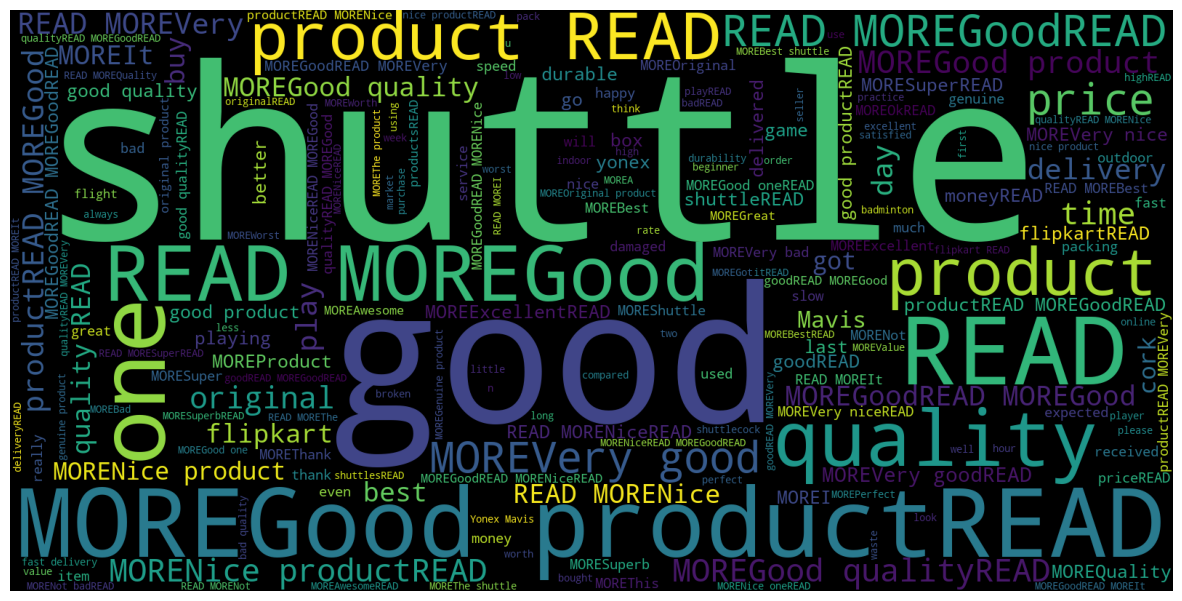

In [25]:
# Converting all the rows of reviews into a paragraph
row_reviews_data = "".join(dataset["Reviews"])

# Displaying the word cloud
display_wc(row_reviews_data)

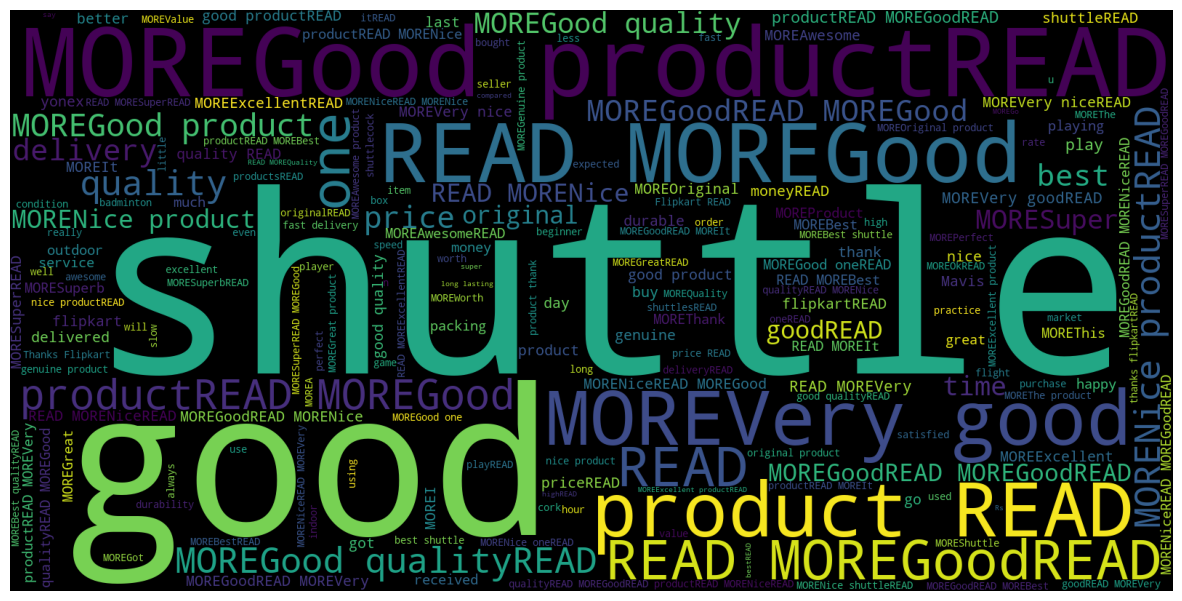

In [26]:
# Filtering out all the positive reviews
positive_reviews = dataset[dataset["Sentiments"] == "Positive"]
# Another way to write the same code is
# X_train[y_train== "Positive"]
# Conversion of all the rows of reviews as a paragraph
positive_para = "".join(positive_reviews["Reviews"])

# Display the Positive word cloud
display_wc(positive_para)

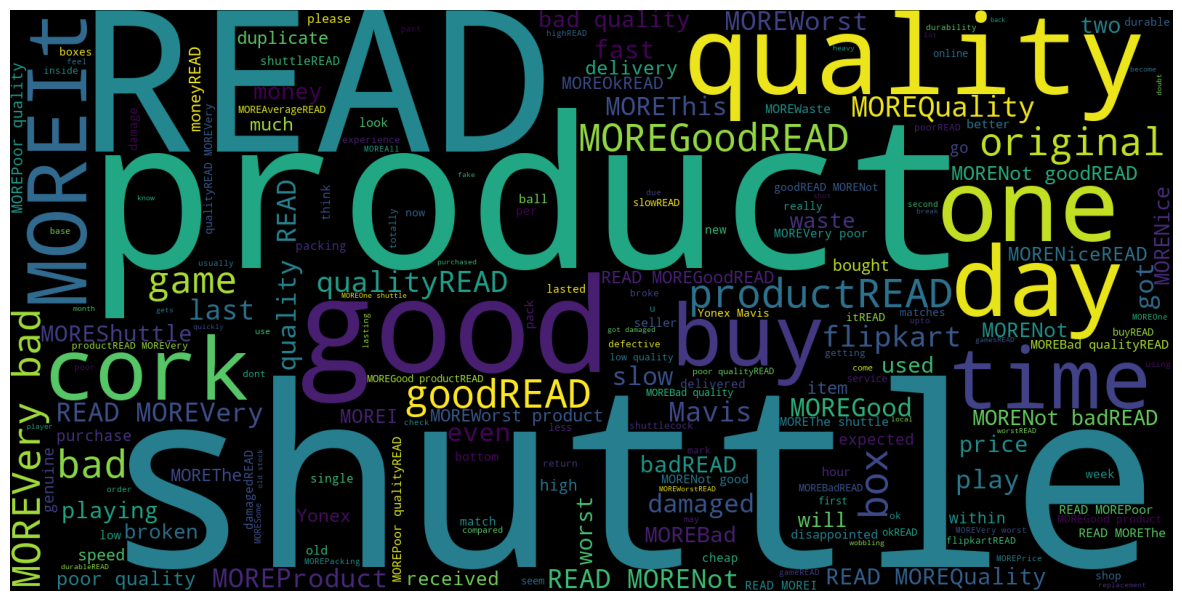

In [27]:
# Filtering out all the Negative reviews
negative_reviews = dataset[dataset["Sentiments"] == "Negative"]
# X_train[y_train == "Negative"]
# Conversion of all the rows of reviews as a paragraph
negative_para = "".join(negative_reviews["Reviews"])

# # Display the Negative Word Cloud
display_wc(negative_para)

###### Observation: 
- If you observe carefully, 'read more' appears to be the most frequently occurring phrase, which is considered as a form of noise and should be addressed.

#### Data Preprocessing

In [28]:
# Initialize WordNetLemmatizer and stopwords
lemma = WordNetLemmatizer()
# Store all the stopwords in the list
sw_list = set(stopwords.words('english'))

def text_preprocessing(review):
    # Replace all the unnecessary words that say "READ MORE"
    review = re.sub(r'\bread\s*more\b', '', review, flags=re.IGNORECASE)
    # Remove all the punctuation and numeric characters
    review = ''.join([char for char in review if char not in string.punctuation and not char.isdigit()])
    # Normalize the case
    review = review.lower()
    # Defining the pattern
    re_spacial_char = r"[^a-z!?\s]"
    # Remove all the special characters
    review = re.sub(re_spacial_char, "", review)
    # Tokenize the text
    review = review.split()
    # Apply the lemmatizer
    review = [lemma.lemmatize(word, pos="v") for word in review if word not in sw_list]
    # Join the text again
    review = " ".join(review)
    return review

In [29]:
print(sw_list)

{'had', 'we', 'yours', 'which', 'are', 'i', 'in', 'of', 'while', "hasn't", 'needn', "shan't", "won't", "you're", 'but', 'between', 'out', 't', 's', 'me', 'yourselves', 'been', 'did', 'can', 'now', "shouldn't", 'where', 'having', "you'd", 've', 'over', 'didn', 'against', 'so', 'then', 'about', 'couldn', "she's", 'what', 'hers', 'his', 'being', 'does', 'ours', "should've", 'at', 'own', 'under', "haven't", 'here', 'further', 'there', 'mightn', 'or', 'd', 'how', 'each', 'aren', 'all', "don't", 'wasn', 'doesn', 'with', "mustn't", "you've", 'once', 'off', 'our', 'only', 'too', 'ain', 'whom', 'have', 'no', 'ourselves', "it's", 'this', 'by', 'through', 'after', 'more', 'above', 'theirs', 'the', 'until', 'on', 'because', 'has', 'them', 'not', 'into', 'its', 'do', 'wouldn', 'will', 'himself', 'myself', "isn't", 'same', 'their', 'll', "mightn't", 'is', 'from', 'few', "hadn't", 'hasn', 'an', 'doing', 'both', "couldn't", 'up', 'nor', "doesn't", 'weren', 'just', 'themselves', 'some', 'they', 'down',

In [30]:
n_stop_words = ["not","couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

In [31]:
print("The length of Stop words: ",len(sw_list))
print("The length of n_stop words: ",len(n_stop_words))

The length of Stop words:  179
The length of n_stop words:  33


In [32]:
sw_list = list(set(sw_list).difference(n_stop_words))

In [33]:
print(len(sw_list))

146


In [34]:
dataset["Reviews"].apply(text_preprocessing)

0       nice product good quality price rise bad sign ...
1       didnt supply yonex mavis outside cover yonex a...
2       worst product damage shuttlecock pack new box ...
3       quite k nowadays quality cork like not years b...
4       pricedjust retaileri didnt understand wat adva...
                              ...                        
8505                   deliver time price high marketread
8506                     mark available market less price
8507                              nice delivery speedread
8508    complaints item best one way price easily avai...
8509    not sure charge product mrp not okay pay rs pr...
Name: Reviews, Length: 8510, dtype: object

In [35]:
# Applying the text_preprocessing function in reviews 
dataset["Reviews"] = dataset["Reviews"].apply(text_preprocessing)

In [36]:
dataset

,Reviews,Sentiments
0,nice product good quality price rise bad sign ...,Positive
1,didnt supply yonex mavis outside cover yonex a...,Negative
2,worst product damage shuttlecock pack new box ...,Negative
3,quite k nowadays quality cork like not years b...,Negative
4,pricedjust retaileri didnt understand wat adva...,Negative
...,...,...
8505,deliver time price high marketread,Negative
8506,mark available market less price,Positive
8507,nice delivery speedread,Positive
8508,complaints item best one way price easily avai...,Positive


### WordCloud After Data Preprocessing

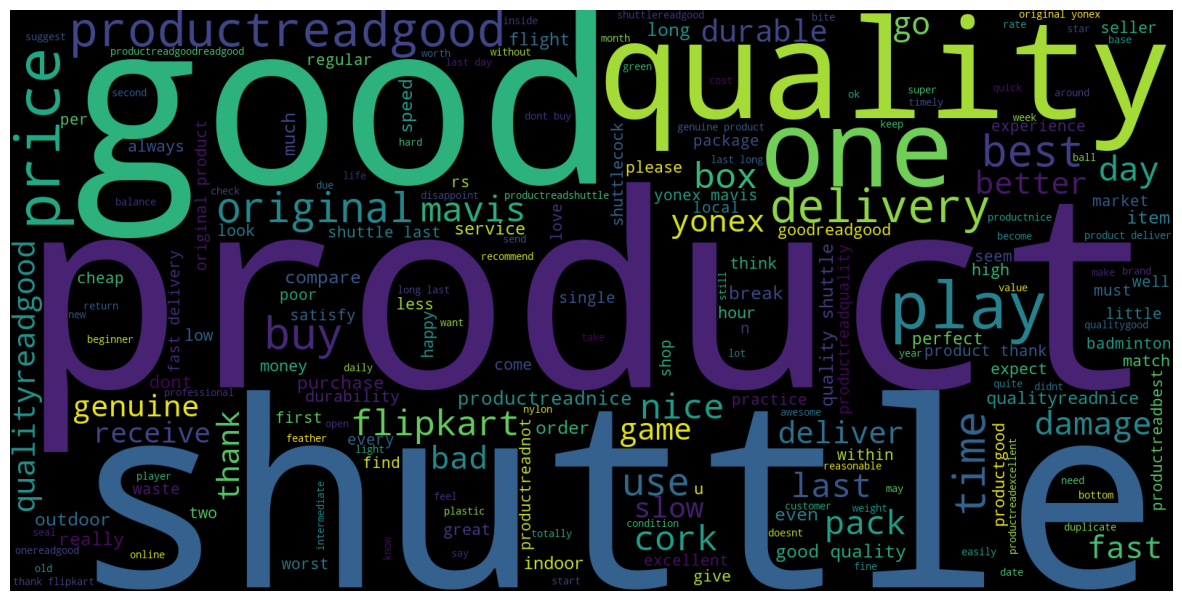

In [37]:
cleaned_review_data = "".join(dataset["Reviews"])
# Display the word cloud
display_wc(cleaned_review_data)

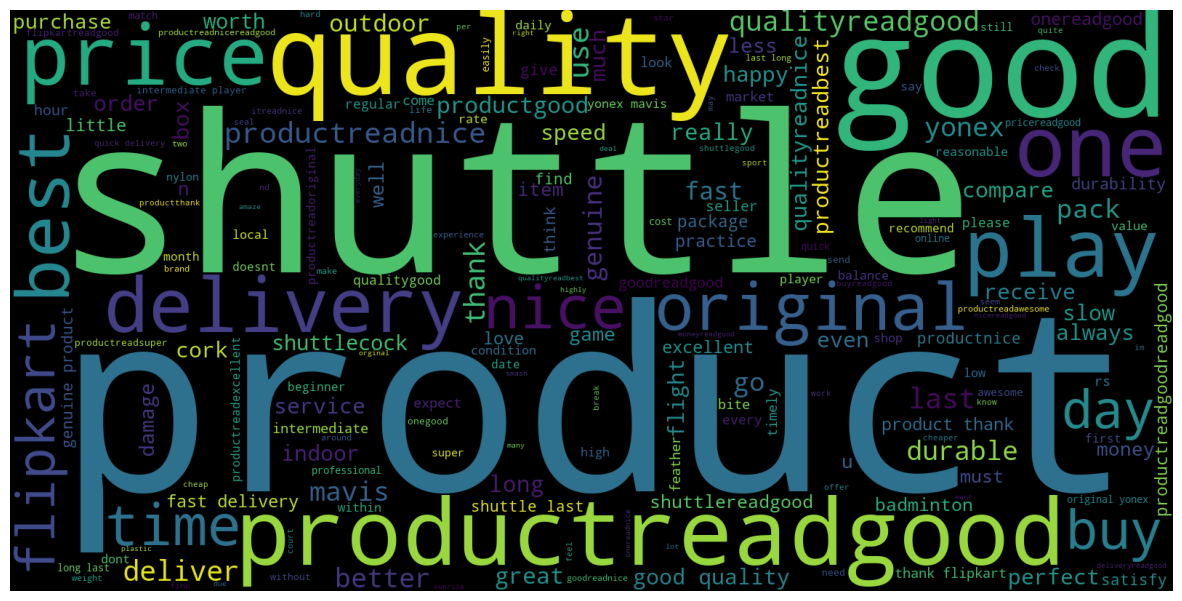

In [38]:
# Filtering out all the positive reviews
cl_positive_reviews_data = dataset[dataset["Sentiments"] == "Positive"]
# Conversion of all the rows of reviews as a paragraph
cl_positive_reviews_para = "".join(cl_positive_reviews_data["Reviews"])

# Display the word cloud
display_wc(cl_positive_reviews_para)

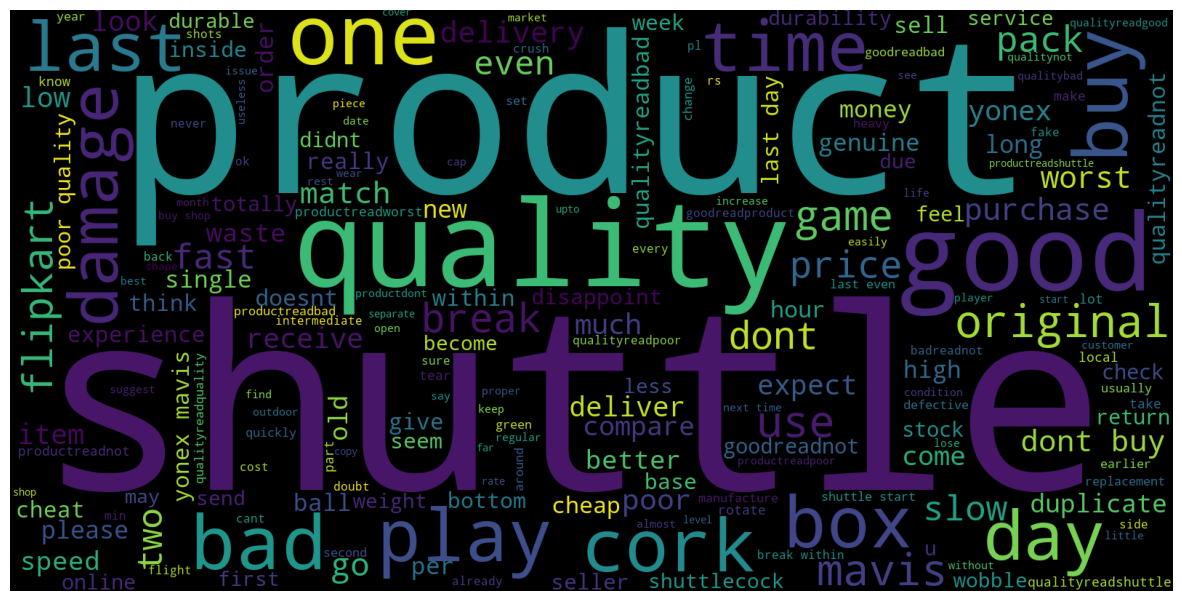

In [39]:
# Filtering out all the Negative reviews
cl_negative_reviews_data = dataset[dataset["Sentiments"] == "Negative"]
# Conversion of all the rows of reviews a paragraph
cl_negative_reviews_para = "".join(cl_negative_reviews_data["Reviews"])

# Display the word cloud
display_wc(cl_negative_reviews_para)

In [40]:
# Initialize the CountVectorizer
cv = CountVectorizer(preprocessor = text_preprocessing)
%time
X_train_dtm = cv.fit_transform(X_train)
# Print the shape of the matrix
X_train_dtm.shape

CPU times: total: 0 ns
Wall time: 0 ns


(6808, 2778)

In [41]:
# Data Preprocessing on text data
X_test_dtm = cv.transform(X_test)
X_test_dtm.shape  #document-term matrix (DTM)

(1702, 2778)

### Naive Bayes Model

In [42]:
# Instantiate the Multinomial Naive Bayes model
m_nb_model = MultinomialNB()

%time
# Fitting the model on train data
m_nb_model.fit(X_train_dtm, y_train)

# Making a prediction on train data
y_pred_train = m_nb_model.predict(X_train_dtm)

# Making a prediction on test data
y_pred = m_nb_model.predict(X_test_dtm)

CPU times: total: 0 ns
Wall time: 0 ns


#### Evaluation:

In [43]:
train_score = accuracy_score(y_pred_train, y_train)

# Checking for the report on train data
print(f"Train Score:: {train_score * 100}")
print(classification_report(y_pred_train, y_train))

Train Score:: 91.40716803760282
              precision    recall  f1-score   support

    Negative       0.66      0.87      0.75      1006
    Positive       0.98      0.92      0.95      5802

    accuracy                           0.91      6808
   macro avg       0.82      0.90      0.85      6808
weighted avg       0.93      0.91      0.92      6808



In [44]:
test_score = accuracy_score(y_pred, y_test)

# Checking for the report on test data
print(f"Test Score:: {test_score*100}")
print(classification_report(y_pred, y_test))

Test Score:: 87.19153936545241
              precision    recall  f1-score   support

    Negative       0.53      0.79      0.64       240
    Positive       0.96      0.89      0.92      1462

    accuracy                           0.87      1702
   macro avg       0.75      0.84      0.78      1702
weighted avg       0.90      0.87      0.88      1702



In [45]:
# Display confusion metrics
metrics.confusion_matrix(y_train, y_pred_train)

array([[ 875,  454],
       [ 131, 5348]], dtype=int64)

In [46]:
m_nb_model.classes_

array(['Negative', 'Positive'], dtype='<U8')

#### Confusion Metrics for Train Score

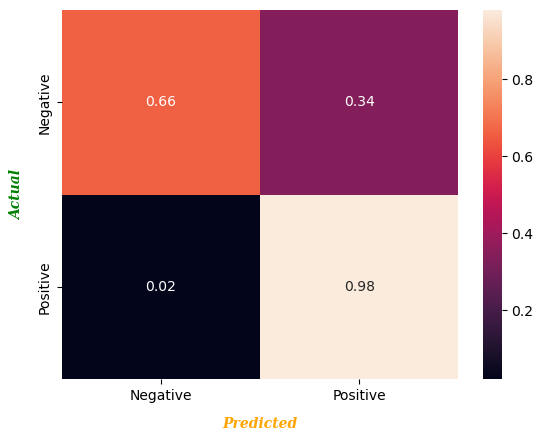

In [47]:
# Creating a confusion metrics for the train score
con_metrics_train = metrics.confusion_matrix(y_train, y_pred_train)

# Calculating the sum
total_sum_train = np.sum(con_metrics_train, axis=1).reshape(2, 1)

# Normalizing the confusion metrics
normalized_con_metrix_train = np.round(con_metrics_train/total_sum_train, 2)

# Creating the heat map of the confusion metrics
sns.heatmap(normalized_con_metrix_train, annot = True, fmt = ".2f", xticklabels = m_nb_model.classes_, yticklabels = m_nb_model.classes_)
plt.xlabel("Predicted", labelpad = 10, fontdict = {
    "family": "serif",
    "size": 10,
    "weight": "bold",
    "style": "italic",
    "color": "Orange"
})
plt.ylabel("Actual", labelpad = 10, fontdict = {
    "family": "serif",
    "size": 10,
    "weight": "bold",
    "style": "italic",
    "color": "Green"
})
plt.show()

#### Confusion Metrics for Test Score

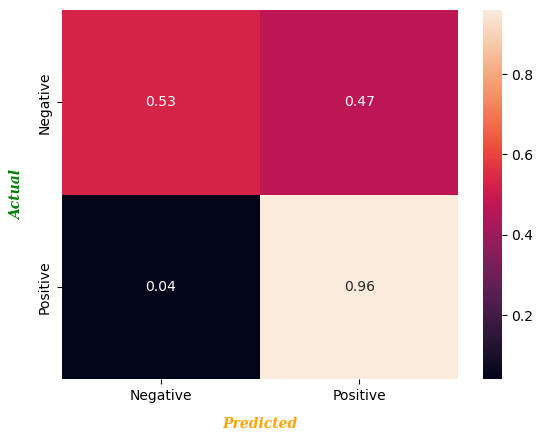

In [48]:
# Creating a confusion metrics for the test score
con_metrics_test = metrics.confusion_matrix(y_test, y_pred)

# Colculation of sum
total_sum_test = np.sum(con_metrics_test, axis = 1).reshape(-1, 1)

# Normalizing the metrics
normalized_con_metrix_test =  np.round(con_metrics_test/total_sum_test, 2)

# Creating the heat map of the confusion metrics
sns.heatmap(normalized_con_metrix_test, annot = True, fmt = ".2f", xticklabels = m_nb_model.classes_, yticklabels = m_nb_model.classes_)
plt.xlabel("Predicted", labelpad = 10, fontdict = {
    "family": "serif",
    "size": 10,
    "weight": "bold",
    "style": "italic",
    "color": "Orange"
})
plt.ylabel("Actual", labelpad = 10, fontdict = {
    "family": "serif",
    "size": 10,
    "weight": "bold",
    "style": "italic",
    "color": "Green"
})
plt.show()

### Logistic Regression

In [49]:
# Create the instance of the class
lor_model = LogisticRegression()
lor_model.fit(X_train_dtm, y_train)

LogisticRegression()

In [50]:
# Making prediction on train and test data
y_train_pred = lor_model.predict(X_train_dtm)
y_pred = lor_model.predict(X_test_dtm)

# Checking for the train and test score
train_score = accuracy_score(y_train, y_pred_train)
test_score = accuracy_score(y_test, y_pred)

In [51]:
# Printing the Comprehensive report for the train score
print(f"Train Score:: {train_score * 100}")
print(classification_report(y_train, y_pred_train))

Train Score:: 91.40716803760282
              precision    recall  f1-score   support

    Negative       0.87      0.66      0.75      1329
    Positive       0.92      0.98      0.95      5479

    accuracy                           0.91      6808
   macro avg       0.90      0.82      0.85      6808
weighted avg       0.91      0.91      0.91      6808



In [52]:
# Printing the Comprehensive report for the test score
print(f"Test Score:: {test_score*100}")
print(classification_report(y_test, y_pred))

Test Score:: 89.36545240893066
              precision    recall  f1-score   support

    Negative       0.86      0.59      0.70       358
    Positive       0.90      0.98      0.94      1344

    accuracy                           0.89      1702
   macro avg       0.88      0.78      0.82      1702
weighted avg       0.89      0.89      0.89      1702



#### Creating Pipelines for optimized workflow

In [53]:
# Implementing Memoization to improve the runtime

In [54]:
%time 
X_train_clean = X_train.apply(lambda doc: text_preprocessing(doc))

%time 
X_test_clean = X_test.apply(lambda doc: text_preprocessing(doc))

CPU times: total: 0 ns
Wall time: 0 ns
CPU times: total: 0 ns
Wall time: 0 ns


In [55]:
# Define a memory object to cache intermediate results
cachedir = ".cache"
memory = Memory(location=cachedir, verbose=0)

pipelines = {
    "naive_bayes": Pipeline([
        ("vectorization", CountVectorizer()),
        ("classifier", MultinomialNB())
    ], memory=memory),
    
    "decision_tree": Pipeline([
        ("vectorization", CountVectorizer()),
        ("classifier", DecisionTreeClassifier())
    ], memory=memory),
    
    "logistic_regression": Pipeline([
        ("vectorization", CountVectorizer()),
        ("classifier", LogisticRegression())
    ], memory=memory),
    
    "knn" : Pipeline([
        ("vectorization", CountVectorizer()),
        ("classifier", KNeighborsClassifier())
    ], memory=memory)
}


# Define parameter grid for each algorithm
param_grids = {
    "naive_bayes": [
        {
            "vectorization": [CountVectorizer(), TfidfVectorizer()],
            "vectorization__max_features" : [1000, 1500, 2000, 5000], 
            "classifier__alpha" : [1, 10]
        }
    ],
    
    "decision_tree": [
        {
            "vectorization": [CountVectorizer(), TfidfVectorizer()],
            "vectorization__max_features" : [1000, 1500, 2000, 5000],
            "classifier__max_depth": [None, 5, 10]
        }
    ],
    
    "logistic_regression": [
        {
            "vectorization": [CountVectorizer(), TfidfVectorizer()],
            "vectorization__max_features" : [1000, 1500, 2000, 5000], 
            "classifier__C": [0.1, 1, 10], 
            "classifier__penalty": ["elasticnet"], 
            "classifier__l1_ratio": [0.4, 0.5, 0.6],
            "classifier__solver": ["saga"],
            "classifier__class_weight": ["balanced"]
        }
    ],
    
    "knn": [
        {
            "vectorization": [CountVectorizer(), TfidfVectorizer()],
            "vectorization__max_features" : [1000, 1500, 2000, 5000],
            "classifier__n_neighbors": [3, 5, 7],
            "classifier__p" : [1, 2, 3]
        }
    ]
}

In [56]:
from sklearn.metrics import make_scorer, f1_score
f1_scorer = make_scorer(f1_score, pos_label = "Positive")

# Perform GridSearchCV for each algorithm
best_models = {}

for algo in pipelines.keys():
    print("*"*10, algo, "*"*10)
    grid_search = GridSearchCV(estimator = pipelines[algo], 
                           param_grid = param_grids[algo], 
                           cv = 5, 
                           scoring = f1_scorer, 
                           return_train_score = True,
                           verbose = 1
                          )
    
    %time grid_search.fit(X_train_clean, y_train)
    
    best_models[algo] = grid_search.best_estimator_
    
    print("Score on Test Data: ", grid_search.score(X_test_clean, y_test))

********** naive_bayes **********
Fitting 5 folds for each of 16 candidates, totalling 80 fits
CPU times: total: 32.1 s
Wall time: 39.3 s
Score on Test Data:  0.9244060475161987
********** decision_tree **********
Fitting 5 folds for each of 24 candidates, totalling 120 fits
CPU times: total: 55 s
Wall time: 1min 5s
Score on Test Data:  0.9259786476868327
********** logistic_regression **********
Fitting 5 folds for each of 72 candidates, totalling 360 fits
CPU times: total: 9min 19s
Wall time: 10min 57s
Score on Test Data:  0.9277510188958874
********** knn **********
Fitting 5 folds for each of 72 candidates, totalling 360 fits
CPU times: total: 19min 49s
Wall time: 8min 9s
Score on Test Data:  0.9244948599787309


In [57]:
for name, model in best_models.items():
    print(f"{name}")
    print(f"{model}")
    print()

naive_bayes
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=1500)),
                ('classifier', MultinomialNB(alpha=1))])

decision_tree
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', TfidfVectorizer(max_features=1500)),
                ('classifier', DecisionTreeClassifier(max_depth=10))])

logistic_regression
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=5000)),
                ('classifier',
                 LogisticRegression(C=1, class_weight='balanced', l1_ratio=0.6,
                                    penalty='elasticnet', solver='saga'))])

knn
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=1000)),
                ('classifier', KNeighborsClassifier(n_neighbors=7))])



********** naive_bayes **********
CPU times: total: 0 ns
Wall time: 0 ns
Test Score (F1) 0.9244060475161987


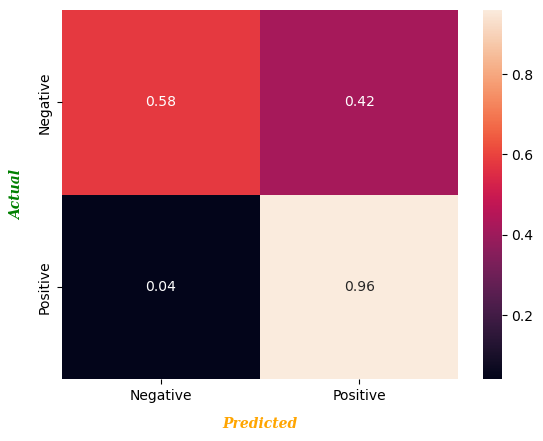

********** decision_tree **********
CPU times: total: 0 ns
Wall time: 16.7 ms
Test Score (F1) 0.9259786476868327


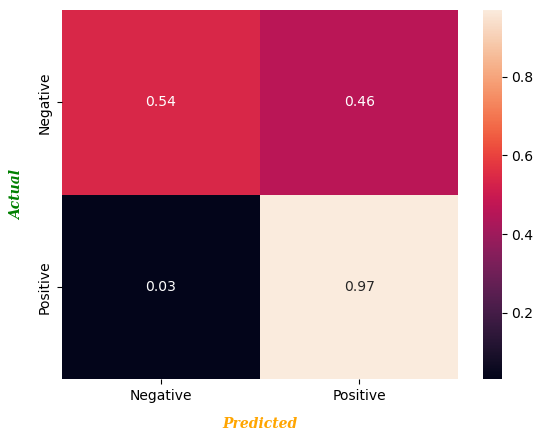

********** logistic_regression **********
CPU times: total: 15.6 ms
Wall time: 15.6 ms
Test Score (F1) 0.9277510188958874


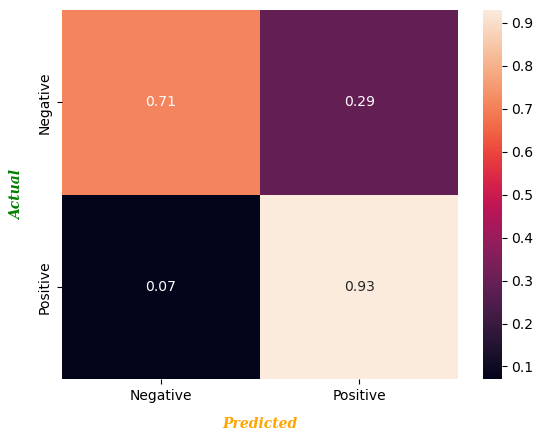

********** knn **********
CPU times: total: 328 ms
Wall time: 414 ms
Test Score (F1) 0.9244948599787309


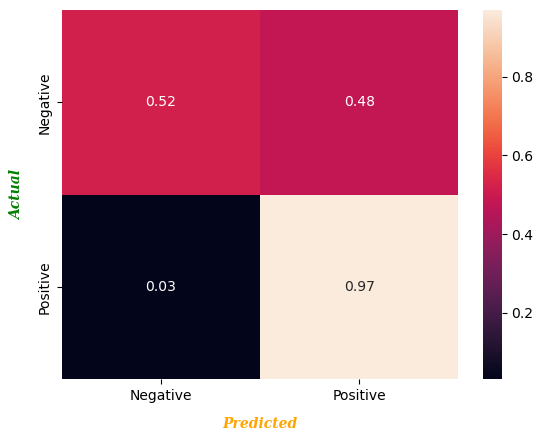

In [58]:
for name, model in best_models.items():
    print("*"*10, name, "*"*10)
    
    # Model Serialization
    joblib.dump(model, f"best_models/{name}.pkl")
    # Model Deserialization
    model = joblib.load(f"best_models/{name}.pkl")
    
    # Prediction on test data
    %time y_test_pred = model.predict(X_test_clean)
    
    # Calculate F1 score with the correct positive label
    print("Test Score (F1)", metrics.f1_score(y_test, y_test_pred, pos_label = "Positive"))
    
    # Creating a confusion metrics for the train score
    con_metrics = metrics.confusion_matrix(y_test, y_test_pred)

    # Calculating the sum
    total_sum = np.sum(con_metrics, axis=1).reshape(2, 1)

    # Normalizing the confusion metrics
    normalized_con_metrix = np.round(con_metrics/total_sum, 2)

    # Creating the heat map of the confusion metrics
    sns.heatmap(normalized_con_metrix, annot=True, fmt=".2f", xticklabels=m_nb_model.classes_, yticklabels=m_nb_model.classes_)
    plt.xlabel("Predicted", labelpad = 10, fontdict = {
        "family": "serif",
        "size": 10,
        "weight": "bold",
        "style": "italic",
        "color": "Orange"
    })
    plt.ylabel("Actual", labelpad = 10, fontdict = {
        "family": "serif",
        "size": 10,
        "weight": "bold",
        "style": "italic",
        "color": "Green"
    })
    plt.show()


#### Real Time Prediction

In [59]:
review = ["I believe that it's the best packaged tea in the market. The taste is something you would cherish for long after having a cup of tea. Long leaves give an enchanting aroma which draws you in the kitchen while tea brews. Packaging is of high quality and appealing. The packaging colour is golden to reflect GOLD. Buy once and you will forget other brands.READ MORE"]


In [60]:
model = joblib.load("best_models/logistic_regression.pkl")

In [61]:
model.predict(review)

array(['Positive'], dtype=object)

In [62]:
review = ["Very nice and super qwality tea taste are greater so i am really empress your service and qwality price some one high but I don't compare price and choices so i am so happy to choose this product thank you very much ekart and his seller's to faster deliveryREAD MORE"]

In [63]:
model.predict(review)

array(['Positive'], dtype=object)

In [64]:
review = ["""Avoid purchasing this shirt at all costs. Upon its first wash, yellow stains inexplicably appeared,
This is not a garment built to last; it's a one-time-use item at best.
Save yourself the trouble and invest in something of better quality."""]

In [65]:
model.predict(review)

array(['Negative'], dtype=object)

In [66]:
review = ["""Shirt looks very good.... But after first wash it become a shabby cloth.... Dont buy this product..."""]

In [67]:
model.predict(review)

array(['Negative'], dtype=object)